# WEATHER AND CRIME IN NEW YORK CITY

At the time I conducted this analysis in May 2025, spring was well on its way and summer was breaking out in New York City. Sure, the flowers bloom at this time of the year; but I had also heard that hot weather increases tensions and can bring out the worst in people. Using NYC MTA data, could I analyze whether there might be a correlation between the weather and crime? I set out to find out.

# HYPOTHESIS

**There is a positive correlation between temperature and the number of crimes on NYC subways and buses (crimes increase in warmer weather)**

# ANALYSIS
I first downloaded data from the MTA open data sets at data.ny.gov and also temperature data among others from the NOAA US federal agency for their Central Park station. Since the MTA open data for crimes committed only goes back to 2019 while the weather data goes back to at least 1980, the analysis will be limited to 2019 for the purposes of this Jupyter Notebook.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

crime = pd.read_csv("./MTA_Major_Felonies_20250509.csv", parse_dates=["Month"])
weather = pd.read_csv("./weather_noaa.csv", parse_dates=["DATE"])

# have a look at what I've loaded to make sure it makes sense 

crime.head(), weather.head()

(       Month Agency Police Force     Felony Type  Felony Count  \
 0 2019-01-01    MNR        MTAPD        Burglary             1   
 1 2019-01-01    MNR        MTAPD  Felony Assault             3   
 2 2019-01-01    MNR        MTAPD          Murder             0   
 3 2019-01-01    MNR        MTAPD            Rape             0   
 4 2019-01-01    MNR        MTAPD         Robbery             1   
 
    Crimes per Million Riders  
 0                       0.15  
 1                       0.44  
 2                       0.00  
 3                       0.00  
 4                       0.15  ,
        STATION                         NAME  LATITUDE  LONGITUDE  ELEVATION  \
 0  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
 1  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
 2  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
 3  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
 4 

Since (at least initially) I'm going for a holistic view of all of the data, I'm going to simplify all of these disparate crime (felony) types into just "Total Crimes" for a particular month.

In [4]:
monthly_crime = crime.groupby("Month")["Felony Count"].sum().reset_index()
monthly_crime.columns = ["Date", "Total_Crimes"]
# Let's see how it looks so far
monthly_crime.head()

,Date,Total_Crimes
0,2019-01-01,214
1,2019-02-01,207
2,2019-03-01,183
3,2019-04-01,194
4,2019-05-01,215


So far so good. Now I have aggregated all of the crime data by month. Time to prepare the weather data so that it makes sense. From earlier I know that I have max temperature, min temperature, and precipation columns. I'm going to go ahead and ensure that the data here is numeric and that I aggregate them by month to match the crime data per month.

In [5]:
weather["TMAX"] = pd.to_numeric(weather["TMAX"], errors="coerce")
weather["TMIN"] = pd.to_numeric(weather["TMIN"], errors="coerce")
weather["PRCP"] = pd.to_numeric(weather["PRCP"], errors="coerce")

weather["Month"] = weather["DATE"].dt.to_period("M").dt.to_timestamp()

monthly_weather = weather.groupby("Month").agg({
    "TMAX": "mean",
    "TMIN": "mean",
    "PRCP": "sum"
}).reset_index()

monthly_weather.columns = ["Date", "Avg_TMAX", "Avg_TMIN", "Total_PRCP"]
monthly_weather.head()

,Date,Avg_TMAX,Avg_TMIN,Total_PRCP
0,1980-01-01,39.354839,28.000000,1.72
1,1980-02-01,37.931034,24.827586,1.04
2,1980-03-01,48.483871,33.870968,10.41
3,1980-04-01,62.700000,46.333333,8.26
4,1980-05-01,74.612903,56.645161,2.33


Now that I have two dataframes ready and cleaned up, one for monthly crime and one for monthly_weather, it's time to merge them to finish the analysis.

This is equivalent to doing an INNER JOIN on two tables on the shared "Date" column in SQL

In [6]:
df = pd.merge(monthly_crime, monthly_weather, on="Date", how="inner")
df.head()

,Date,Total_Crimes,Avg_TMAX,Avg_TMIN,Total_PRCP
0,2019-01-01,214,39.032258,26.000000,3.58
1,2019-02-01,207,42.642857,29.785714,3.14
2,2019-03-01,183,48.709677,34.741935,3.87
3,2019-04-01,194,63.300000,47.600000,4.55
4,2019-05-01,215,69.935484,54.387097,6.82


I'll plot crime against temperature to see if it has any effect

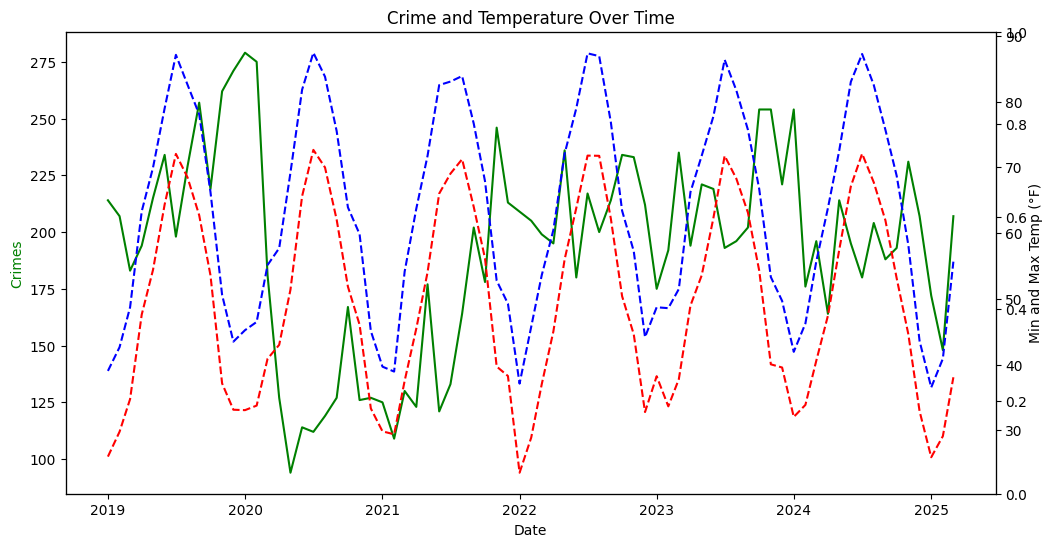

In [11]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()
ax1.plot(df["Date"], df["Total_Crimes"], 'g-', label="Total Crimes")
ax2.plot(df["Date"], df["Avg_TMAX"], 'b--', label="Avg Max Temp")

ax3 = ax1.twinx()
ax2.plot(df["Date"], df["Avg_TMIN"], 'r--', label="Avg Min Temp")

ax1.set_ylabel("Crimes", color="g")
ax2.set_ylabel("Min and Max Temp (°F)", color="black")
ax1.set_xlabel("Date")
plt.title("Crime and Temperature Over Time")
plt.show()

In [1]:
corr_subset = df[["Avg_TMAX", "Avg_TMIN", "Total_PRCP" "Total_Crimes"]]
sns.heatmap(corr_subset.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix: Crime vs Weather")
plt.show()

NameError: name 'df' is not defined

Alright! So this is interesting. While we are looking for a correlation between crime and temperature,  

The usual hypothesis is that there is a positive correlation between the temperature and the number of crimes being committed.

However the line chart actually does not provide that much support for this hypothesis. The largest spike was in 2020 - at the height of the COVID-19 pandemic - at a time when temperatures had actually hit their lowest!

Granted, let's discount the COVID-19 spike in crime as an outlier. Subsequently it appears that the crime rate spikes as temperatures are on their way down. Prominent examples of this are in Fall 2021 and Fall 2023.

In fact, there seems to be little correlation between surges in crime and the temperature. There are visible surges in crime over the summers of 2022 and 2023.

The Pearson correlation matrix gives a numerical read on this. It shows that, contrary to the hypothesis, there is a very small (almost nonexistent) negative correlation between temperature and crime rate. So small as to be negligible.

# CONCLUSION

I set out to test the hypothesis that there is a positive correlation between temperature and the number of crimes on NYC subways and buses (crimes increase in warmer weather).

However, both a visual analysis and an analysis through a Pearson correlation matrix are very weak, and in fact slightly negative. This suggests that the weather is not a reliable predictor of crimes on NYC subways and buses.

So in conclusion, in NYC's MTA transportation system weather **does not appear to meaningfully explain crime variation**. It is possible that other factors such as ridership levels or perhaps economic conditions shape crime trends instead.